In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load SMOTE-enhanced data
train_df = pd.read_csv(r"C:\Users\86135\Desktop\5703\train_smote.csv")
test_df  = pd.read_csv(r"C:\Users\86135\Desktop\5703\test_smote.csv")

# Separate features and labels
X_train = train_df.drop(columns=['failure mode']).values.astype(np.float32)
y_train = train_df['failure mode'].values
X_test  = test_df.drop(columns=['failure mode']).values.astype(np.float32)
y_test  = test_df['failure mode'].values

# Encode labels to integers (in case they are not numeric)
classes, y_train_encoded = np.unique(y_train, return_inverse=True)
_, y_test_encoded  = np.unique(y_test, return_inverse=True)
num_classes = len(classes)
print(f"Number of classes: {num_classes}")

# Standardize features (fit on train, apply to both)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Convert data to torch tensors for MLP training/evaluation
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long, device=device)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_test_tensor  = torch.tensor(y_test_encoded, dtype=torch.long, device=device)

print(f"Train samples: {X_train_tensor.size(0)}, Test samples: {X_test_tensor.size(0)}")
print(f"Feature dimension: {X_train_tensor.size(1)}")


Using device: cpu
Number of classes: 4
Train samples: 600, Test samples: 86
Feature dimension: 69


In [17]:
# Prepare data by class for task sampling
classes = np.unique(y_train_encoded)
train_indices_by_class = {cls: np.where(y_train_encoded == cls)[0] for cls in classes}

# Define MAML model (2 outputs for 2-way classification)
class MAMLLearner(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 2)  # 2 outputs for 2-way tasks
    def forward(self, x, weights=None):
        if weights is None:
            # Standard forward using internal params
            x = self.relu(self.fc1(x))
            return self.fc2(x)
        else:
            # Forward using a custom weight set (for inner loop)
            w1, b1, w2, b2 = weights
            x = F.linear(x, w1, b1)
            x = self.relu(x)
            x = F.linear(x, w2, b2)
            return x

input_dim = X_train_tensor.size(1)
maml_model = MAMLLearner(input_dim, hidden_dim=64).to(device)
meta_optimizer = torch.optim.Adam(maml_model.parameters(), lr=0.001)
inner_lr = 0.01
num_meta_epochs = 1000
meta_batch = 4  # tasks per meta-update

meta_losses = []
for epoch in range(1, num_meta_epochs+1):
    maml_model.train()
    meta_optimizer.zero_grad()
    meta_loss = 0.0

    for _ in range(meta_batch):
        # Sample 2 distinct classes for this task
        cls_sample = np.random.choice(classes, size=2, replace=False)
        # Map original class labels to {0,1}
        class_map = {cls_sample[0]: 0, cls_sample[1]: 1}
        support_indices = []
        query_indices = []
        # For each class, sample 5 support and 10 query
        for cls in cls_sample:
            idx = train_indices_by_class[cls]
            perm = np.random.permutation(len(idx))
            support_idx = idx[perm[:5]]
            query_idx = idx[perm[5:15]]  # next 10 for query
            support_indices.extend(support_idx)
            query_indices.extend(query_idx)
        
        # Create support and query sets
        X_support = torch.tensor(X_train_scaled[support_indices], dtype=torch.float32, device=device)
        y_support = torch.tensor([class_map[y] for y in y_train_encoded[support_indices]],
                                 dtype=torch.long, device=device)
        X_query   = torch.tensor(X_train_scaled[query_indices], dtype=torch.float32, device=device)
        y_query   = torch.tensor([class_map[y] for y in y_train_encoded[query_indices]],
                                 dtype=torch.long, device=device)

        # Compute gradients on support set
        logits_s = maml_model(X_support)
        loss_s = criterion(logits_s, y_support)
        grads = torch.autograd.grad(loss_s, [maml_model.fc1.weight, maml_model.fc1.bias,
                                             maml_model.fc2.weight, maml_model.fc2.bias],
                                    create_graph=True)
        # Fast-adapted weights
        fast_w1 = maml_model.fc1.weight - inner_lr * grads[0]
        fast_b1 = maml_model.fc1.bias   - inner_lr * grads[1]
        fast_w2 = maml_model.fc2.weight - inner_lr * grads[2]
        fast_b2 = maml_model.fc2.bias   - inner_lr * grads[3]
        fast_weights = (fast_w1, fast_b1, fast_w2, fast_b2)

        # Compute query loss using adapted weights
        logits_q = maml_model(X_query, weights=fast_weights)
        loss_q = criterion(logits_q, y_query)
        meta_loss += loss_q

    # Average meta-loss across tasks
    meta_loss = meta_loss / meta_batch
    meta_loss.backward()
    meta_optimizer.step()
    meta_losses.append(meta_loss.item())

    if epoch % 200 == 0:
        print(f"Meta-epoch {epoch}/{num_meta_epochs} - Meta Loss: {meta_loss.item():.4f}")


Meta-epoch 200/1000 - Meta Loss: 0.6530
Meta-epoch 400/1000 - Meta Loss: 0.4438
Meta-epoch 600/1000 - Meta Loss: 0.3488
Meta-epoch 800/1000 - Meta Loss: 0.2120
Meta-epoch 1000/1000 - Meta Loss: 0.1501


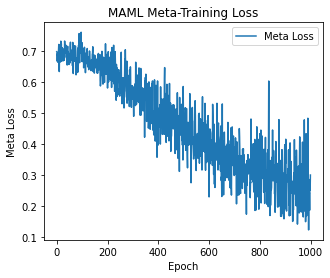

In [15]:
# Plot MAML meta-training loss curve
plt.figure(figsize=(5,4))
plt.plot(meta_losses, label='Meta Loss')
plt.title("MAML Meta-Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Meta Loss")
plt.legend()
plt.show()


In [16]:
# Prepare test indices by class
test_indices_by_class = {cls: np.where(y_test_encoded == cls)[0] for cls in classes}

maml_model.eval()
num_test_tasks = 100
accs, precs, recs, f1s = [], [], [], []
for _ in range(num_test_tasks):
    # Sample 2 classes and construct a test task
    cls_sample = np.random.choice(classes, size=2, replace=False)
    class_map = {cls_sample[0]: 0, cls_sample[1]: 1}
    supp_idx, qry_idx = [], []
    for cls in cls_sample:
        idx = test_indices_by_class[cls]
        if len(idx) < 15:
            continue  # skip if not enough examples
        perm = np.random.permutation(len(idx))
        supp_idx.extend(idx[perm[:5]])
        qry_idx.extend(idx[perm[5:15]])
    if len(supp_idx) < 10 or len(qry_idx) < 20:
        continue

    X_supp = torch.tensor(X_test_scaled[supp_idx], dtype=torch.float32, device=device)
    y_supp = torch.tensor([class_map[y] for y in y_test_encoded[supp_idx]],
                           dtype=torch.long, device=device)
    X_qry = torch.tensor(X_test_scaled[qry_idx], dtype=torch.float32, device=device)
    y_qry = torch.tensor([class_map[y] for y in y_test_encoded[qry_idx]],
                           dtype=torch.long, device=device)

    # Inner adaptation on support
    logits_s = maml_model(X_supp)
    loss_s = criterion(logits_s, y_supp)
    grads = torch.autograd.grad(loss_s, [maml_model.fc1.weight, maml_model.fc1.bias,
                                         maml_model.fc2.weight, maml_model.fc2.bias], create_graph=False)
    fast_w1 = maml_model.fc1.weight - inner_lr * grads[0]
    fast_b1 = maml_model.fc1.bias   - inner_lr * grads[1]
    fast_w2 = maml_model.fc2.weight - inner_lr * grads[2]
    fast_b2 = maml_model.fc2.bias   - inner_lr * grads[3]
    fast_weights = (fast_w1, fast_b1, fast_w2, fast_b2)

    # Prediction on query with adapted weights
    logits_q = maml_model(X_qry, weights=fast_weights)
    preds = torch.argmax(logits_q, dim=1).cpu().numpy()
    true = y_qry.cpu().numpy()

    # Compute metrics for this task
    accs.append((preds == true).mean())
    precs.append(precision_score(true, preds, average='macro', zero_division=0))
    recs.append(recall_score(true, preds, average='macro', zero_division=0))
    f1s.append(f1_score(true, preds, average='macro', zero_division=0))

# Average metrics across test tasks
acc_maml = np.mean(accs)
precision_maml = np.mean(precs)
recall_maml = np.mean(recs)
f1_maml = np.mean(f1s)

print("MAML on Test Tasks (2-way):")
print(f"  Accuracy: {acc_maml:.4f}")
print(f"  Precision (macro): {precision_maml:.4f}")
print(f"  Recall (macro):    {recall_maml:.4f}")
print(f"  F1-score (macro):  {f1_maml:.4f}")


MAML on Test Tasks (2-way):
  Accuracy: 0.8891
  Precision (macro): 0.8965
  Recall (macro):    0.8891
  F1-score (macro):  0.8884
